In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

sns.set_style("darkgrid")

data = pd.read_csv('predictive_maintenance.csv')

data.head()

data["Failure Type"].value_counts()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [11]:
data = data.drop(["UDI",'Product ID'],axis=1)
data.head(3)

data.groupby(['Target','Failure Type']).count()

data.groupby(['Target','Failure Type']).count().drop(['Process temperature [K]',
                                                      'Rotational speed [rpm]',
                                                     'Torque [Nm]',
                                                     'Tool wear [min]',
                                                      'Air temperature [K]'],axis=1).rename(columns = {'Type':'count'})

data.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [12]:
data.groupby(['Target','Failure Type']).median()

data.groupby(['Type','Target']).median()

data.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Failure Type'],
      dtype='object')

In [13]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

label_encoder.fit(data['Type'])
data['Type'] = label_encoder.transform(data['Type'])

label_encoder.fit(data['Target'])
data['Target'] = label_encoder.transform(data['Target'])



data.tail()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
9995,2,298.8,308.4,1604,29.5,14,0,No Failure
9996,0,298.9,308.4,1632,31.8,17,0,No Failure
9997,2,299.0,308.6,1645,33.4,22,0,No Failure
9998,0,299.0,308.7,1408,48.5,25,0,No Failure
9999,2,299.0,308.7,1500,40.2,30,0,No Failure


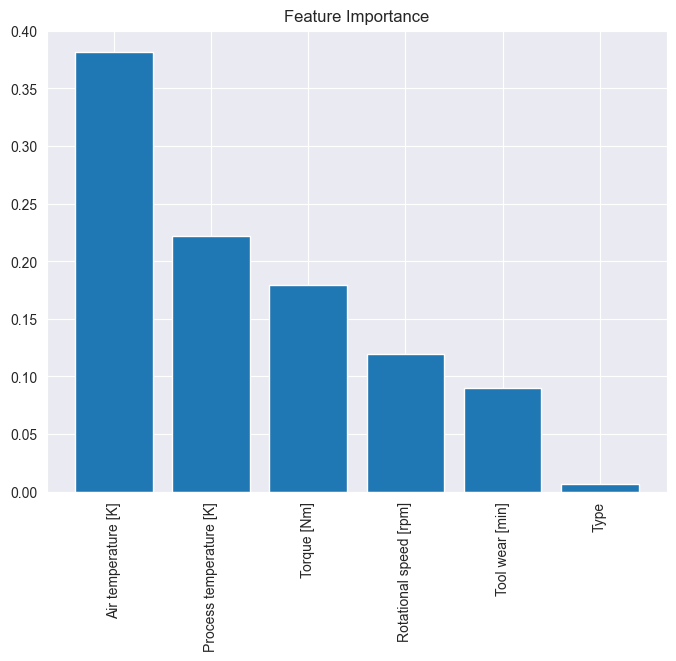

In [24]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8,6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), [data.columns[i] for i in indices], rotation=90)
plt.show()

In [15]:
y=data[data["Target"]==1]

x=data[data["Target"]==0]

X=x[:1000].reset_index(drop=True)

result = pd.concat([X, y])

Result=result.reset_index(drop=True)

Result["Target"].value_counts()

0    1000
1     339
Name: Target, dtype: int64

In [16]:
from imblearn.over_sampling import SMOTE
f=SMOTE(sampling_strategy="minority")
x_smote,y_smote=f.fit_resample(Result.drop(['Failure Type','Target'],axis=1),Result['Target'])

pd.Series(y_smote).value_counts()

0    1000
1    1000
Name: Target, dtype: int64

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_smote,y_smote, test_size=0.3, random_state=42)

from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(n_estimators=300,
    max_depth=20,
    min_samples_split=2)

In [18]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}


In [19]:
model.fit(X_train,y_train)

model.score(X_test,y_test)

0.9833333333333333

In [20]:
y_pred=model.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix
t=classification_report(y_test,y_pred)
print(t)

f=confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       302
           1       0.98      0.98      0.98       298

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



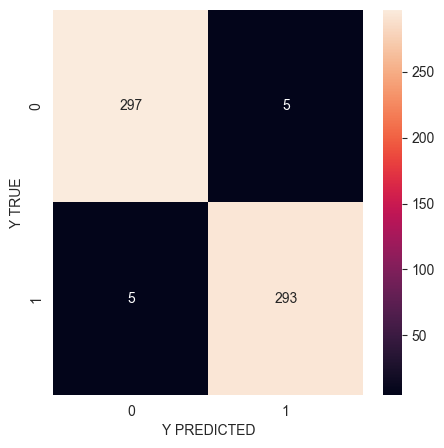

numpy.int64

In [21]:
import matplotlib.pyplot as plt

import seaborn as sn
plt.figure(figsize=(5,5))
sn.heatmap(f,annot=True,fmt="d")
plt.ylabel("Y TRUE")
plt.xlabel("Y PREDICTED")
plt.show()

r=model.predict([[2,297.2,308.2,3678,8.1,133]])

type(r[0])

In [22]:
import pickle

with open("maint.pickle4","wb") as sp:
    pickle.dump(model,sp)

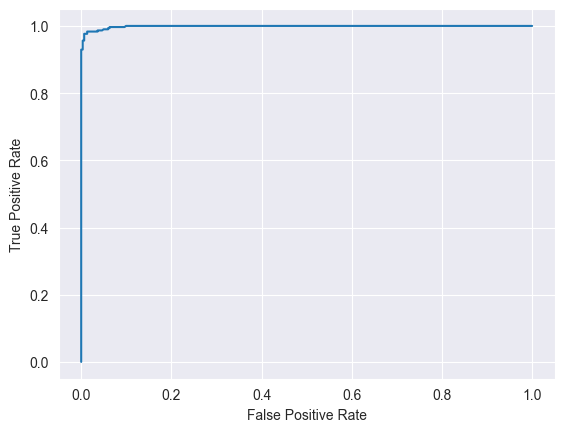

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


In [25]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-Validation Scores: ", scores)


Cross-Validation Scores:  [0.97142857 0.98928571 0.975      0.98214286 0.97857143]
